# GENERADOR DE ALBUMES

# 0. Importación packages y constantes

In [2]:
import os.path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

# Packages propios
from utils.objectdetection import ObjectDetectionHelper
from utils.graphdbmanipulation import ImagesGraphDB
from utils.imagesmanipulation import ImageHelper
from utils.analytics import AnalyticsHelper

In [2]:
# GRAFO DE DETECCIÓN DE OBJETOS COCO y PERSONALIZADOS
PATH_COCO_AND_CUSTOM_OBJECTS_GML_FILE = './outputs/graph_databases/graph_OBJECTS_CANDLES.gml'
PATH_RIVERS_LAKES_GML_FILE = './outputs/graph_databases/graph_RIVERS_LAKES.gml'
PATH_GEO_TIME_GML_FILE = './outputs/graph_databases/graph_GEO_TIME.gml'
PATH_FACE_RECOG_GML_FILE = './outputs/graph_databases/graph_FACE_RECOG.gml'
MIN_IMAGES_TRIP = 20

# 1. CARGA DE GRAFOS EXTRAÍDOS Y DE ETIQUETAS MANUALES

In [3]:
imagesGraphDB = ImagesGraphDB()
imagesGraphDB.load_graph_from_gml_file(PATH_COCO_AND_CUSTOM_OBJECTS_GML_FILE)
imagesGraphDB.load_graph_from_gml_file(PATH_RIVERS_LAKES_GML_FILE)
imagesGraphDB.load_graph_from_gml_file(PATH_GEO_TIME_GML_FILE)
imagesGraphDB.load_graph_from_gml_file(PATH_FACE_RECOG_GML_FILE)

In [4]:
df_images_labeled_manually = pd.read_excel('./resources/manual_labels/etiquetado_manual_imagenes.xlsx',skiprows=1)
df_images_labeled_manually.head(10)

,Image,Viaje,Comida,Cena,Cumpleaños,Retrato,Maria,Biel,Yo,Piscina,...,Tenedor,Cuchillo,Cuchara,bowl,pastel,silla,Mesa,Plato,Vaso,Llama vela
0,20210724_100218.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
1,20210724_104730.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,20210724_104736.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,20210724_104739.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,20210724_104743.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,20210724_104757.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6,20210724_200143.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
7,20210724_200145.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
8,20210724_200231_02.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
9,20210724_200231_03.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


# 2. EVENTOS

## 2.1. COMIDAS Y CENAS

### 2.1.1. Obtención de las imagenes predecidas de comidas y cenas

El algoritmo utilizado se basaria en los siguientes pasos:
- encontrar imagenes que contengan mesas, botellas y vasos de vino
- obtener el dia en que fueron tomadas esas fotos y en que franja horaria (madrugada, mañana, tarde o noche)
- obtener el resto de fotos de esos dias y franjas horarias, al ser muy probables que pertenezcan al mismo evento comida o cena.

In [32]:
# Creo función para detectar intersecciones en listas
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [33]:
# Se obtiene las imágenes del grafo que se relacionan con los nodos "dining table","bottle" y "wine glass"
object_classes_to_filter = ['dining table'] # Se cogerán las imágenes con pasteles, personas y velas encendidas
dining_table_images_list = imagesGraphDB.get_images_containing_list_object_types(['dining table'])
bottle_images_list = imagesGraphDB.get_images_containing_list_object_types(['bottle'])
wine_glass_list = imagesGraphDB.get_images_containing_list_object_types(['wine glass'])

# Se busca la intersección de los tres conjuntos de imágenes
lunch_dinner_detected_list = intersection(dining_table_images_list,bottle_images_list)
lunch_dinner_detected_list = intersection(lunch_dinner_detected_list,wine_glass_list)


In [34]:
# Se buscan las fechas
df_lunch_dinner_detected_dates = imagesGraphDB.get_neighbours_by_type_of_node_list(lunch_dinner_detected_list,'image_filename','fecha')
# Se obtienen las franjas de los conjuntos de imágenes obtenidos
df_lunch_dinner_detected_franjas = imagesGraphDB.get_neighbours_by_type_of_node_list(lunch_dinner_detected_list,'image_filename','franja')

In [35]:
# Se cruzan los datos de franjas horarias y fechas
df_lunch_dinner_detected = pd.merge(df_lunch_dinner_detected_dates,df_lunch_dinner_detected_franjas,on='image_filename')

In [36]:
# Se separan las imágenes de comidas y cenas detectadas en función de las franjas horarias
df_lunch_detected = df_lunch_dinner_detected[df_lunch_dinner_detected['franja']=='afternoon']
df_supper_detected = df_lunch_dinner_detected[df_lunch_dinner_detected['franja'].isin(['night','early_morning'])]

In [37]:
# Se busca el listado de imagenes en los mismos días y franjas horarias porque se considera probable que pertenezcan al mismo evento de comida o cena

# COMIDAS
df_total_lunch_candidates_images = imagesGraphDB.get_neighbours_by_type_of_node_list(list(set(df_lunch_detected['fecha'].to_list())),'fecha','image_filename')
total_lunch_candidates_images_list = df_total_lunch_candidates_images['image_filename'].to_list()
df_total_lunch_candidates_images_franja = imagesGraphDB.get_neighbours_by_type_of_node_list(total_lunch_candidates_images_list,'image_filename','franja')
df_lunch_images_predicted = df_total_lunch_candidates_images_franja[df_total_lunch_candidates_images_franja['franja'].isin(['afternoon'])]
df_lunch_images_predicted = pd.merge(df_lunch_images_predicted,df_total_lunch_candidates_images,on='image_filename')

#CENAS
df_total_supper_candidates_images = imagesGraphDB.get_neighbours_by_type_of_node_list(list(set(df_supper_detected['fecha'].to_list())),'fecha','image_filename')
total_supper_candidates_images_list = df_total_supper_candidates_images['image_filename'].to_list()
df_total_supper_candidates_images_franja = imagesGraphDB.get_neighbours_by_type_of_node_list(total_supper_candidates_images_list,'image_filename','franja')
df_supper_images_predicted = df_total_supper_candidates_images_franja[df_total_supper_candidates_images_franja['franja'].isin(['night','early_morning'])]
df_supper_images_predicted = pd.merge(df_supper_images_predicted,df_total_supper_candidates_images,on='image_filename')

### 2.1.2. Matrices de confusión y métricas

#### Cenas

Se prepara un dataframe con las columnas reales y predecidas de cenas

In [38]:
df_supper_images_predicted['Cena predicted'] = 1
df_images_supper_manual = df_images_labeled_manually[['Image','Cena']].copy()
df_supper_analysis = df_images_labeled_manually.merge(df_supper_images_predicted , how="left", left_on="Image", right_on="image_filename")
# Se informa con valor 0 aquellas imagenes sin detección de rios y lagos
# en lugar de NA
df_supper_analysis['Cena predicted'] = df_supper_analysis['Cena predicted']. fillna(0)

# Se convierte a int la columna ya que se usa como booleano
df_supper_analysis['Cena predicted'] = df_supper_analysis['Cena predicted'].astype('int')

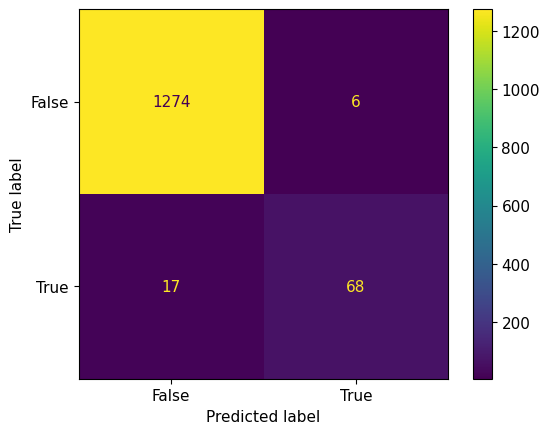

In [39]:
from sklearn import metrics
%matplotlib inline
# Se cargan los resultados de la predicción y el real
images_supper_actual= df_supper_analysis['Cena'].to_numpy()
images_supper_predicted= df_supper_analysis['Cena predicted'].to_numpy()
# Se cargan los datos para generar la matriz de confusión
confusion_matrix = metrics.confusion_matrix(images_supper_actual, images_supper_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# Se muestra el gráfico
cm_display.plot()
plt.show()

Se obtienen las métricas

In [40]:
analyticsHelper = AnalyticsHelper()
metrics = analyticsHelper.getBinaryClassificationConfusionMatrixMetrics(confusion_matrix)
metrics

{'recall': 0.8,
 'precision': 0.918918918918919,
 'accuracy': 0.9831501831501831,
 'specificity': 0.9953125,
 'f1_score': 0.8553459119496855}

#### Comidas

In [43]:
df_lunch_images_predicted['Comida predicted'] = 1
df_images_lunch_manual = df_images_labeled_manually[['Image','Comida']].copy()
df_lunch_analysis = df_images_labeled_manually.merge(df_lunch_images_predicted , how="left", left_on="Image", right_on="image_filename")
# Se informa con valor 0 aquellas imagenes sin detección de rios y lagos
# en lugar de NA
df_lunch_analysis['Comida predicted'] = df_lunch_analysis['Comida predicted']. fillna(0)

# Se convierte a int la columna ya que se usa como booleano
df_lunch_analysis['Comida predicted'] = df_lunch_analysis['Comida predicted'].astype('int')

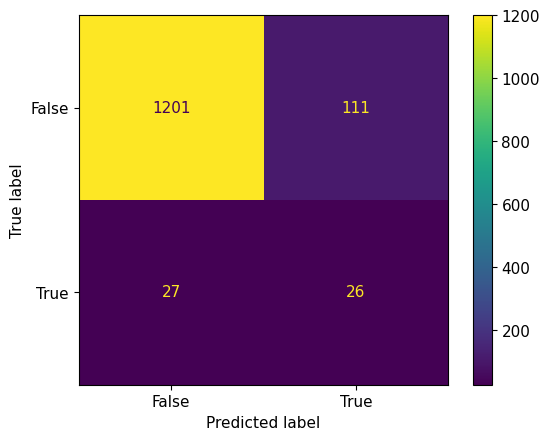

In [44]:
from sklearn import metrics

# Se cargan los resultados de la predicción y el real
images_lunch_actual= df_lunch_analysis['Comida'].to_numpy()
images_lunch_predicted= df_lunch_analysis['Comida predicted'].to_numpy()
# Se cargan los datos para generar la matriz de confusión
confusion_matrix = metrics.confusion_matrix(images_lunch_actual, images_lunch_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# Se muestra el gráfico
cm_display.plot()
plt.show()

Se obtienen las métricas

In [45]:
analyticsHelper = AnalyticsHelper()
metrics = analyticsHelper.getBinaryClassificationConfusionMatrixMetrics(confusion_matrix)
metrics

{'recall': 0.49056603773584906,
 'precision': 0.1897810218978102,
 'accuracy': 0.8989010989010989,
 'specificity': 0.9153963414634146,
 'f1_score': 0.2736842105263158}

### 2.1.3. Albumes agrupados por dia

#### Cenas

In [53]:
df_supper_images_predicted['Evento'] = "Cena_" + df_supper_images_predicted[['fecha']]
df_supper_albumes = df_supper_images_predicted.groupby(['Evento']).aggregate({'image_filename':'count'})
df_supper_albumes

,image_filename
Evento,
Cena_2021_11_20,33
Cena_2021_12_31,11
Cena_2021_8_25,2
Cena_2021_9_2,4
Cena_2021_9_4,7
Cena_2022_12_23,1
Cena_2022_1_1,15
Cena_2022_7_28,1


#### Comidas

In [54]:
df_lunch_images_predicted['Evento'] = "Comida_" + df_lunch_images_predicted[['fecha']]
df_lunch_albumes = df_lunch_images_predicted.groupby(['Evento']).aggregate({'image_filename':'count'})
df_lunch_albumes

,image_filename
Evento,
Comida_2021_8_15,3
Comida_2021_8_27,105
Comida_2022_5_8,2
Comida_2022_7_31,4
Comida_2022_8_31,23


## 2.2. CUMPLEAÑOS

### 2.2.1. Obtención de imagenes predecidas

In [18]:
# Se obtiene las imágenes del grafo que se relacionan con los nodos "person", "cake" y "candle_light"
object_classes_to_filter = ['person','cake','candle_light'] # Se cogerán las imágenes con pasteles, personas y velas encendidas
birhtday_images_list = imagesGraphDB.get_images_containing_list_object_types(object_classes_to_filter)

# Se obtienen las fechas de las imagenes de cumpleaños
df_birthday_dates = imagesGraphDB.get_neighbours_by_type_of_node_list(birhtday_images_list,'image_filename','fecha')

# Se busca el listado de imagenes de esos dias
df_birthday_images = imagesGraphDB.get_neighbours_by_type_of_node_list(list(set(df_birthday_dates['fecha'].to_list())),'fecha','image_filename')


### 2.2.2. Albumes de cumpleaños por dia

Se obtiene el número de imágenes por fecha de celebración de cumpleaños

In [19]:
df_birthday_albumes_proposal = df_birthday_images.groupby(['fecha']).aggregate({'image_filename':'count'})
df_birthday_albumes_proposal.rename(columns = {'image_filename':'numero_imagenes'},inplace=True)
df_birthday_albumes_proposal

,numero_imagenes
fecha,
2021_8_26,31
2021_9_19,5
2021_9_6,12
2022_4_18,4
2022_9_18,11


Tres de los cinco álbumes de cumpleaños propuestos lo serían realmente. Uno de ellos se trata de una celebración con pastel y el otro es realmente una cena en que se confunde un plato de carne con un pastel. Hay una foto de cumpleaños que no se detecta, pero tres de los cuatro cumpleaños de los que se disponen de imagenes son detectados y propuesto un album.

# 3. ESCENAS

## 3.1. LAGOS Y RIOS

### 3.1.1. Obtención de imagenes predecidas

In [67]:
# Se cargan las imágenes que han sido detectadas en ambos modelos de detección de rios y lagos
rivers_lakes_images_list = imagesGraphDB.get_images_containing_list_object_types_with_min_confidence(['water','water2'],[0.7,0.7])
df_rivers_lakes_images_months = imagesGraphDB.get_neighbours_by_type_of_node_list(rivers_lakes_images_list,'image_filename','mes')
df_rivers_lakes_images_year = imagesGraphDB.get_neighbours_by_type_of_node_list(rivers_lakes_images_list,'image_filename','anyo')


In [75]:
# Se obtiene un dataframe que especifique el año y el mes de cada imagen
df_rivers_lakes_images = pd.merge(df_rivers_lakes_images_year,df_rivers_lakes_images_months,on='image_filename')
# Se le añade la columna "album"
df_rivers_lakes_images['Escena'] = 'rivers_lakes_'+df_rivers_lakes_images['mes'] +'_'+df_rivers_lakes_images['anyo']

In [78]:
df_rivers_lakes_images

,image_filename,anyo,mes,Escena
0,20210731_145146.jpg,2021,7,river_lake_7_2021
1,20210731_145608.jpg,2021,7,river_lake_7_2021
2,20210826_201433.jpg,2021,8,river_lake_8_2021
3,20210826_201434.jpg,2021,8,river_lake_8_2021
4,20210827_120642.jpg,2021,8,river_lake_8_2021
...,...,...,...,...
67,20210903_105241.jpg,2021,9,river_lake_9_2021
68,20210903_200124.jpg,2021,9,river_lake_9_2021
69,20210903_200317.jpg,2021,9,river_lake_9_2021
70,20210904_113705.jpg,2021,9,river_lake_9_2021


### 3.1.2. Albumes agrupados por mes y año

In [77]:
# Se pasa a agrupar por mes y año
df_rivers_lakes_albumes = df_rivers_lakes_images.groupby(['Escena']).aggregate({'image_filename':'count'})
df_rivers_lakes_albumes

,image_filename
Escena,
river_lake_10_2022,2
river_lake_11_2021,5
river_lake_11_2022,1
river_lake_12_2021,1
river_lake_1_2023,1
river_lake_5_2018,3
river_lake_7_2021,2
river_lake_8_2021,16
river_lake_8_2022,12


En caso de querer solo escenas de rios y lagos que representen baños, se podrian descartar todos aquellos albumes que no sean de junio a septiembre.

# 4. VIAJES

## 4.1. Obtención de imagenes con geolocalización

Se obtiene la información del grafo de imagenes a más de 100km de la residencia habitual y se complementan con información de la provincia, comunidad autonoma y año.

In [10]:
# Primero se obtienen las imagnes obtenidas en ubicaciones a mas de 100km
images = imagesGraphDB.get_images_distance_gt(200)
# Se obtienen las provincias de las imagenes a mas de 200km
df_province = imagesGraphDB.get_neighbours_by_type_of_node_list(images,'image_filename','provincia')
# Se obtiene el año en que fue tomada cada imagen
df_year = imagesGraphDB.get_neighbours_by_type_of_node_list(images,'image_filename','anyo')

Se junta la información en un solo dataframe

In [11]:
df_images_albumes = pd.merge(df_province,df_year,on='image_filename')
df_images_albumes

,image_filename,provincia,anyo
0,20210826_195318.jpg,Soria,2021
1,20210826_195324.jpg,Soria,2021
2,20210826_195328.jpg,Soria,2021
3,20210826_200606.jpg,Soria,2021
4,20210826_200610.jpg,Soria,2021
...,...,...,...
298,20210831_122453.jpg,Burgos,2021
299,20210831_123216.jpg,Burgos,2021
300,20210831_130745.jpg,Burgos,2021
301,20210831_130851.jpg,Burgos,2021


## 4.2. Albumes Agrupados por provincia y año

In [13]:
df_images_albumes['viajes'] = df_images_albumes['provincia'] +'_'+ df_images_albumes['anyo']
df_trip_albumes_proposal = df_images_albumes.groupby(['viajes']).aggregate({'image_filename':'count'})
df_trip_albumes_proposal.rename(columns = {'image_filename':'numero_imagenes'},inplace=True)
df_trip_albumes = df_trip_albumes_proposal[df_trip_albumes_proposal['numero_imagenes']>MIN_IMAGES_TRIP]

In [14]:
df_trip_albumes

,numero_imagenes
viajes,
Burgos_2021,65
Cantabria_2021,84
Soria_2021,152


Mediante esta técnica se han detectado tres viajes que forman parte de las vacaciones de verano realizadas en el año 2021 y de las cuales se disponían de coordenadas de latitud y longitud.

## 4.3. Álbumes detectados frecuencias de toma de fotos

Lo primero es calcular la frecuencia de toma de fotos promedio por año.

In [64]:
# Se obtienen las imagenes del grafo
images_list = imagesGraphDB.get_nodes_filtered_by_type('image_filename')
# Se obtiene el año de estas imágenes
df_images_year = imagesGraphDB.get_neighbours_by_type_of_node_list(images_list,'image_filename','anyo')
df_images_date = imagesGraphDB.get_neighbours_by_type_of_node_list(images_list,'image_filename','fecha')

In [65]:
# Se calcula el número de imagenes por año
df_images_average_per_year = df_images_year.groupby(['anyo']).aggregate({'image_filename':'count'})
df_images_average_per_year.rename(columns = {'image_filename':'numero_imagenes'},inplace=True)
df_images_average_per_year['promedio_imagenes_dia'] = df_images_average_per_year['numero_imagenes']/365
df_images_average_per_year

,numero_imagenes,promedio_imagenes_dia
anyo,,
2018,5,0.013699
2021,870,2.383562
2022,445,1.219178
2023,45,0.123288


Se observa que más de tres imagenes por dia es una anomalia. Se pasa a calcular para cada imagen el promedio de fotos de la ventana de tres dias anteriores y de tres dias posteriores incluyendo el dia de toma de la imagen

In [69]:
df_images_count_per_date = df_images_date.groupby(['fecha']).aggregate({'image_filename':'count'})
df_images_count_per_date.rename(columns = {'image_filename':'numero_imagenes'},inplace=True)
df_images_count_per_date.reset_index(inplace=True)


In [70]:
df_images_count_per_date = pd.DataFrame(df_images_count_per_date)
df_images_count_per_date['anyo'] = df_images_count_per_date['fecha'].apply(lambda x: int(x.split('_')[0]))
df_images_count_per_date['mes'] = df_images_count_per_date['fecha'].apply(lambda x: int(x.split('_')[1]))
df_images_count_per_date['dia'] = df_images_count_per_date['fecha'].apply(lambda x: int(x.split('_')[2]))

In [71]:
df_images_count_per_date_ordered = df_images_count_per_date.sort_values(by=['anyo','mes','dia'],ascending=True).copy()
df_images_count_per_date_ordered

,fecha,numero_imagenes,anyo,mes,dia
0,2018_5_5,3,2018,5,5
1,2018_8_22,1,2018,8,22
2,2018_8_24,1,2018,8,24
17,2021_7_24,17,2021,7,24
18,2021_7_25,33,2021,7,25
...,...,...,...,...,...
120,2023_2_16,1,2023,2,16
121,2023_2_17,6,2023,2,17
122,2023_2_18,3,2023,2,18
123,2023_2_25,1,2023,2,25


In [72]:
# Se eliminan todos los dias que no esten por encima de 5 veces la media anual
df_images_count_per_date_filtered = df_images_count_per_date_ordered[df_images_count_per_date_ordered['numero_imagenes']>10].copy()

df_images_count_per_date_filtered

,fecha,numero_imagenes,anyo,mes,dia
17,2021_7_24,17,2021,7,24
18,2021_7_25,33,2021,7,25
19,2021_7_31,85,2021,7,31
25,2021_8_22,14,2021,8,22
26,2021_8_23,39,2021,8,23
28,2021_8_26,31,2021,8,26
29,2021_8_27,121,2021,8,27
31,2021_8_29,21,2021,8,29
32,2021_8_30,34,2021,8,30
33,2021_8_31,45,2021,8,31


In [81]:
import datetime
counter = 0
num_images_day_before = 0
num_images_current_day = 0
trip_days_list = []
trips = []
trips_first_last_day = []
trip =[]
first_iteration = True
num_days_current_trip = 1
# Se averiguan los días que forman viajes a partir de días consecutivos o
# alternativos con frecuencia de fotografías 5 veces por encima de la media anual
for row in df_images_count_per_date_filtered.itertuples():
    current_date = datetime.date(row.anyo,row.mes,row.dia)
    if  first_iteration:
        trip.append(row.fecha)
        first_iteration = False
    else:
        if (current_date - before_date).days<=2:
            trip.append(row.fecha)
            num_days_current_trip = num_days_current_trip + (current_date - before_date).days
        else:
            if num_days_current_trip>=3:
                trips.append(trip)
            trip = []
            trip.append(row.fecha)
            num_days_current_trip = 1

    before_date= current_date
# Se obtienen las fechas de inicio y fin de los albumes
for trip in trips:
    counter =0
    first_day_current_trip= ''
    last_day_current_trip = ''
    for day in trip:
        if counter == 0:
            first_day_current_trip = day
        counter +=1
        last_day_current_trip = day
        trip_days_list.append(day)
    print ('trip: '+ first_day_current_trip +'-'+last_day_current_trip)
    trips_first_last_day.append((first_day_current_trip,last_day_current_trip))


trip: 2021_8_26-2021_9_6
trip: 2022_8_19-2022_8_26


In [82]:
# Se obtiene el año, mes y día para todas las imágenes y su fecha en formato datetime

df_images_date['anyo'] = df_images_date['fecha'].apply(lambda x: int(x.split('_')[0]))
df_images_date['mes'] = df_images_date['fecha'].apply(lambda x: int(x.split('_')[1]))
df_images_date['dia'] = df_images_date['fecha'].apply(lambda x: int(x.split('_')[2]))
df_images_date['datetime'] = df_images_date.apply((lambda x: datetime.date(x.anyo,x.mes,x.dia)),axis=1)


In [116]:
# Se consiguen todas las imágenes de los días de viaje
trips_images=[]
for first_last_day in trips_first_last_day:
    first_day_date = datetime.datetime.strptime(first_last_day[0],'%Y_%m_%d').date()
    last_day_date = datetime.datetime.strptime(first_last_day[1],'%Y_%m_%d').date()
    df_images_date_trip = df_images_date[df_images_date['datetime']>=first_day_date].copy()
    df_images_date_trip= df_images_date_trip[df_images_date['datetime']<=last_day_date]
    trips_images = trips_images + df_images_date_trip['image_filename'].tolist()

C:\Users\dcsj\AppData\Local\Temp\ipykernel_18684\3946465280.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_images_date_trip= df_images_date_trip[df_images_date['datetime']<=last_day_date]


In [117]:
# Se cruzan los datos para obtener dataframe con predicciones y real
df_trips_images_final = pd.DataFrame(trips_images,columns=['image_filename'])
df_trips_images_final['Viaje predicted']= 1
df_trips_images_manual = df_images_labeled_manually[['Image','Viaje']]
df_trips_analysis = df_trips_images_manual.merge(df_trips_images_final , how="left", left_on="Image", right_on="image_filename")
# Se informa con valor 0 aquellas imagenes sin detección de Viajes
# en lugar de NA
df_trips_analysis['Viaje predicted'] = df_trips_analysis['Viaje predicted']. fillna(0)

# Se convierte a int la columna ya que se usa como booleano
df_trips_analysis['Viaje predicted'] = df_trips_analysis['Viaje predicted'].astype('int')

Se calculan las matrices de confusión

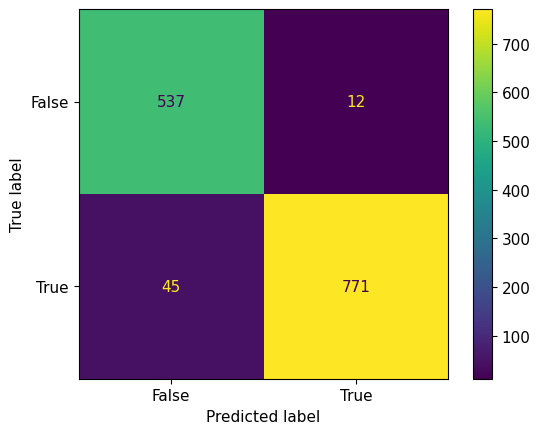

In [118]:
from sklearn import metrics
%matplotlib inline
# Se cargan los resultados de la predicción y el real
images_trips_actual= df_trips_analysis['Viaje'].to_numpy()
images_trips_predicted= df_trips_analysis['Viaje predicted'].to_numpy()
# Se cargan los datos para generar la matriz de confusión
confusion_matrix = metrics.confusion_matrix(images_trips_actual, images_trips_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# Se muestra el gráfico
cm_display.plot()
plt.show()

Se obtienen las métricas de viajes detectados

In [119]:
analyticsHelper = AnalyticsHelper()
metrics = analyticsHelper.getBinaryClassificationConfusionMatrixMetrics(confusion_matrix)
metrics

{'recall': 0.9448529411764706,
 'precision': 0.9846743295019157,
 'accuracy': 0.9582417582417583,
 'specificity': 0.9781420765027322,
 'f1_score': 0.9643527204502814}